In [ ]:
!pip install pyspark

In [ ]:
!pip install xgboost

In [1]:
import pyspark
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("CreditRisk") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")


In [4]:
df = spark.read.csv("/kaggle/input/financial-risk-data-large/financial_risk_analysis_large.csv", inferSchema = True, header = True, sep=',')

In [6]:
# Get the number of rows
num_rows = df.count()

# Get the number of columns
num_columns = len(df.columns)

# Print the results
print(f"Rows: {num_rows}, Columns: {num_columns}")


Rows: 1000000, Columns: 51


In [7]:
df.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- EmploymentStatus: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- NumberOfDependents: integer (nullable = true)
 |-- EducationLevel: string (nullable = true)
 |-- HomeOwnershipStatus: string (nullable = true)
 |-- MonthlyDebtPayments: integer (nullable = true)
 |-- CreditCardUtilizationRate: double (nullable = true)
 |-- NumberOfOpenCreditLines: integer (nullable = true)
 |-- NumberOfCreditInquiries: integer (nullable = true)
 |-- DebtToIncomeRatio: double (nullable = true)
 |-- BankruptcyHistory: integer (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- PreviousLoanDefaults: integer (nullable = true)
 |-- InterestRate: double (nullable = true)
 |-- PaymentHistory: integer (nullable = true)
 |-- SavingsAccountBalance: intege

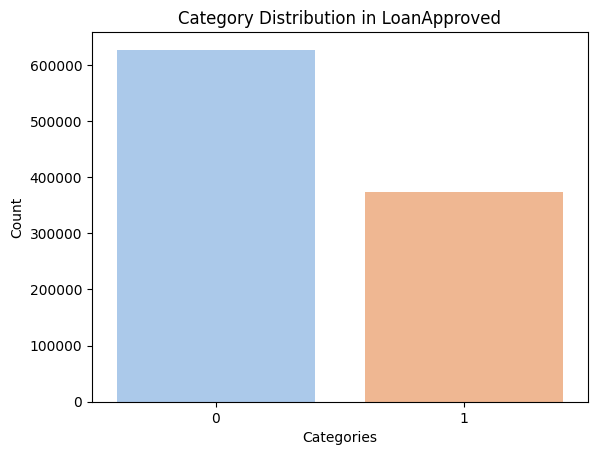

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'LoanApproved' with your feature name
feature = 'LoanApproved'

# Convert the relevant column to a Pandas DataFrame
pandas_df = df.select(feature).toPandas()

# Create the plot
sns.countplot(x=feature, data=pandas_df, palette='pastel')

# Add labels
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title(f'Category Distribution in {feature}')
plt.show()


In [13]:
# Remove specific columns
columns_to_drop = ['MortgageBalance', 'RentPayments', 'AutoLoanBalance', 'PersonalLoanBalance', 'StudentLoanBalance', 'OtherInsurancePolicies', 'JobTenure', 'MonthlySavings', 'AnnualBonuses', 'AnnualExpenses', 'MonthlyHousingCosts', 'MonthlyTransportationCosts', 'MonthlyFoodCosts', 'MonthlyHealthcareCosts', 'MonthlyEntertainmentCosts', 'SavingsAccountBalance', 'CheckingAccountBalance', 'InvestmentAccountBalance', 'RetirementAccountBalance', 'EmergencyFundBalance', 'UtilityBillsPaymentHistory', 'InterestRate', 'HealthInsuranceStatus', 'LifeInsuranceStatus', 'CarInsuranceStatus', 'HomeInsuranceStatus', 'EmployerType', 'BankruptcyHistory' 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines' , 'NumberOfCreditInquiries', 'LengthOfCreditHistory', 'BankruptcyHistory', 'EducationLevel', 'PreviousLoanDefaults', 'LoanPurpose', 'EmploymentStatus', 'MaritalStatus', 'HomeOwnershipStatus']  # Replace with actual column names
df_reduced = df.drop(*columns_to_drop)

# Print schema of reduced dataset
df_reduced.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- NumberOfDependents: integer (nullable = true)
 |-- MonthlyDebtPayments: integer (nullable = true)
 |-- DebtToIncomeRatio: double (nullable = true)
 |-- PaymentHistory: integer (nullable = true)
 |-- TotalAssets: integer (nullable = true)
 |-- TotalLiabilities: integer (nullable = true)
 |-- NetWorth: integer (nullable = true)
 |-- LoanApproved: integer (nullable = true)



In [14]:
trainData, testData = df_reduced.randomSplit([0.8, 0.2], seed=42)

## LogisticRegression

In [15]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT  # Corrected import here

# Step 1: Apply StringIndexer to create categoryIndex for the target column 'LoanApproved'
indexer = StringIndexer(inputCol="LoanApproved", outputCol="categoryIndex")
indexed_data = indexer.fit(df_reduced).transform(df_reduced)

# Step 2: Define your feature columns
features = ['CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 'NumberOfDependents', 'MonthlyDebtPayments', 'DebtToIncomeRatio', 
            'PaymentHistory', 'TotalAssets', 'TotalLiabilities', 'NetWorth']

# Step 3: Define a function to convert rows into feature vectors
def create_feature_vector(*cols):
    return Vectors.dense(cols)

# Step 4: Create a UDF to apply the function on each row
create_vector_udf = udf(create_feature_vector, VectorUDT())

# Step 5: Add the 'features' column using the UDF
indexed_data_with_features = indexed_data.withColumn("features", create_vector_udf(*features))

# Step 6: Define the Logistic Regression model
lr = LogisticRegression(labelCol="categoryIndex", featuresCol="features")

# Step 7: Train the Logistic Regression model
lrModel = lr.fit(indexed_data_with_features)

# Step 8: You can now make predictions or evaluate the model


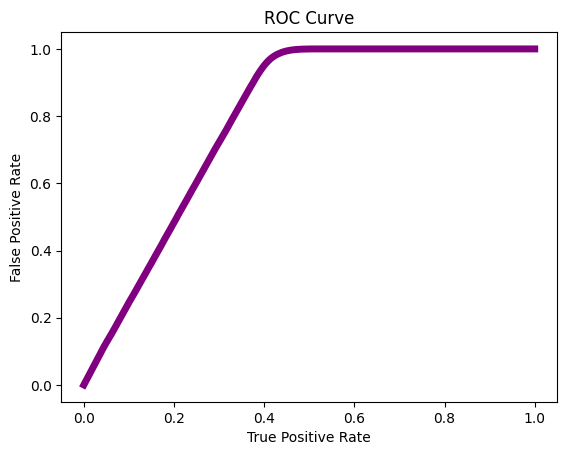

TrainSet areaUnderROC: 0.7919341094293383


In [16]:
trainSet = lrModel.summary
roc = trainSet.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'],linewidth = '5',color = 'Purple')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('TrainSet areaUnderROC: ' + str(trainSet.areaUnderROC))

In [17]:
from pyspark.ml.feature import VectorAssembler

# Assuming these are your input feature columns:
features = ['CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 
            'NumberOfDependents', 'MonthlyDebtPayments', 'DebtToIncomeRatio', 
            'PaymentHistory', 'TotalAssets', 'TotalLiabilities', 'NetWorth']

# Assemble the features into a single vector column named 'features'
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(testData)


In [18]:
# Now you can make predictions on the assembled data
predictions = lrModel.transform(assembled_data)


In [19]:
evaluator = BinaryClassificationEvaluator(labelCol="LoanApproved")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.7903987554848743


In [20]:
predictions.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- NumberOfDependents: integer (nullable = true)
 |-- MonthlyDebtPayments: integer (nullable = true)
 |-- DebtToIncomeRatio: double (nullable = true)
 |-- PaymentHistory: integer (nullable = true)
 |-- TotalAssets: integer (nullable = true)
 |-- TotalLiabilities: integer (nullable = true)
 |-- NetWorth: integer (nullable = true)
 |-- LoanApproved: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [21]:
predictions.select('CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 'DebtToIncomeRatio','rawPrediction','prediction', 'probability').show(10)

+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|CreditScore|AnnualIncome|LoanAmount|LoanDuration|Age|  DebtToIncomeRatio|       rawPrediction|prediction|         probability|
+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|        300|       18957|     16554|           9| 30|0.25048889122682727|[3.12804445865115...|       0.0|[0.95803484257860...|
|        300|       25286|     20933|           4| 65| 0.4644893458725541|[3.08253288307940...|       0.0|[0.95616646593534...|
|        300|       26324|     20215|          19| 50| 0.8867257957281907|[3.07960563195671...|       0.0|[0.95604361457413...|
|        300|       28547|     10964|           7| 26| 0.9514603669242588|[3.04795532977269...|       0.0|[0.95469417013830...|
|        300|       30707|     27852|          19| 19|0.41791155218889864|[3.02770651820098...|       0.

In [24]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Select the necessary columns
rfPredictions = predictions.select('CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 
                                   'DebtToIncomeRatio', 'rawPrediction', 'prediction', 'probability')

# Define the window spec for ordering the rows (e.g., by CreditScore or another column)
windowSpec = Window.orderBy("CreditScore")  # You can change the ordering column if needed

# Add a row number to each row
rfPredictions_with_row_num = rfPredictions.withColumn("row_num", F.row_number().over(windowSpec))

# Get the total count of rows
total_count = rfPredictions_with_row_num.count()

# Filter to get the last 100 rows
last_100_rfPredictions = rfPredictions_with_row_num.filter(rfPredictions_with_row_num["row_num"] > total_count - 100)

# Show the last 100 rows in the same format
last_100_rfPredictions.drop("row_num").show(10)

+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|CreditScore|AnnualIncome|LoanAmount|LoanDuration|Age|  DebtToIncomeRatio|       rawPrediction|prediction|         probability|
+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|        849|       72227|     24792|          19| 55| 0.8967883254362617|[8.49786505894218...|       1.0|[0.42489325294710...|
|        849|       72392|     19037|           2| 61|   0.57723049229739|[8.71498382960940...|       1.0|[0.43574919148047...|
|        849|       72899|     16723|          26| 40|0.47600524749806095|[8.70042083717879...|       1.0|[0.43502104185893...|
|        849|       73107|     21706|          24| 62| 0.7815867075014731|[8.50262062028733...|       1.0|[0.42513103101436...|
|        849|       73332|     33549|          22| 19|0.23238595804709017|[8.68594141028236...|       1.

## Randomforest

In [23]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# Step 1: Apply StringIndexer to create categoryIndex for the target column 'LoanApproved'
indexer = StringIndexer(inputCol="LoanApproved", outputCol="categoryIndex")
indexed_data = indexer.fit(df_reduced).transform(df_reduced)

# Step 2: Define your feature columns
features = ['CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 'NumberOfDependents', 'MonthlyDebtPayments', 'DebtToIncomeRatio', 
            'PaymentHistory', 'TotalAssets', 'TotalLiabilities', 'NetWorth']

# Step 3: Define a function to convert rows into feature vectors
def create_feature_vector(*cols):
    return Vectors.dense(cols)

# Step 4: Create a UDF to apply the function on each row
create_vector_udf = udf(create_feature_vector, VectorUDT())

# Step 5: Add the 'features' column using the UDF
indexed_data_with_features = indexed_data.withColumn("features", create_vector_udf(*features))

# Step 6: Split data into training and testing (this is typically needed for model training and evaluation)
trainData, testData = indexed_data_with_features.randomSplit([0.8, 0.2], seed=1234)

# Step 7: Define the RandomForest model
rf = RandomForestClassifier(labelCol="categoryIndex", featuresCol="features")

# Step 8: Train the RandomForest model
rfModel = rf.fit(trainData)

# Step 9: Make predictions
predictions = rfModel.transform(testData)

# Step 10: Print the schema of the predictions DataFrame
predictions.printSchema()

# Step 11: Optionally, evaluate the model using metrics like accuracy or area under the curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="categoryIndex")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy}")



root
 |-- CreditScore: integer (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- NumberOfDependents: integer (nullable = true)
 |-- MonthlyDebtPayments: integer (nullable = true)
 |-- DebtToIncomeRatio: double (nullable = true)
 |-- PaymentHistory: integer (nullable = true)
 |-- TotalAssets: integer (nullable = true)
 |-- TotalLiabilities: integer (nullable = true)
 |-- NetWorth: integer (nullable = true)
 |-- LoanApproved: integer (nullable = true)
 |-- categoryIndex: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



Model Accuracy: 0.7987818113477421


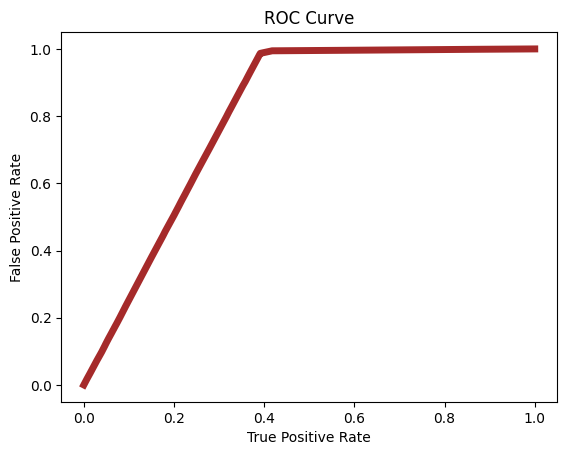

TrainSet areaUnderROC: 0.800201220340569


In [25]:
trainSet = rfModel.summary
roc = trainSet.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'],linewidth = '5',color = 'Brown')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('TrainSet areaUnderROC: ' + str(trainSet.areaUnderROC))

In [26]:
rfPredictions = predictions.select('CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 'DebtToIncomeRatio','rawPrediction','prediction', 'probability').show(10)

+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|CreditScore|AnnualIncome|LoanAmount|LoanDuration|Age|  DebtToIncomeRatio|       rawPrediction|prediction|         probability|
+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|        300|       15780|     20762|          19| 20| 0.6165116796740844|[18.7121542333932...|       0.0|[0.93560771166966...|
|        300|       24090|     19007|          14| 28| 0.6224856021534455|[18.4367547927549...|       0.0|[0.92183773963774...|
|        300|       31909|     13794|          21| 32| 0.6266177646305753|[19.8858121955325...|       0.0|[0.99429060977662...|
|        300|       32493|     22488|          21| 68| 0.5549893971977383|[19.1506520571610...|       0.0|[0.95753260285805...|
|        300|       32531|     20757|           8| 65| 0.6317061996914932|[18.7837228772455...|       0.

In [27]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

rfPredictions = predictions.select('CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 
                                   'DebtToIncomeRatio', 'rawPrediction', 'prediction', 'probability')
windowSpec = Window.orderBy("CreditScore")  

rfPredictions_with_row_num = rfPredictions.withColumn("row_num", F.row_number().over(windowSpec))

total_count = rfPredictions_with_row_num.count()

last_100_rfPredictions = rfPredictions_with_row_num.filter(rfPredictions_with_row_num["row_num"] > total_count - 100)

last_100_rfPredictions.drop("row_num").show(10)


+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|CreditScore|AnnualIncome|LoanAmount|LoanDuration|Age|  DebtToIncomeRatio|       rawPrediction|prediction|         probability|
+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|        849|       72227|     24792|          19| 55| 0.8967883254362617|[8.49786505894218...|       1.0|[0.42489325294710...|
|        849|       72392|     19037|           2| 61|   0.57723049229739|[8.71498382960940...|       1.0|[0.43574919148047...|
|        849|       72899|     16723|          26| 40|0.47600524749806095|[8.70042083717879...|       1.0|[0.43502104185893...|
|        849|       73107|     21706|          24| 62| 0.7815867075014731|[8.50262062028733...|       1.0|[0.42513103101436...|
|        849|       73332|     33549|          22| 19|0.23238595804709017|[8.68594141028236...|       1.

## NaiveBayes

In [28]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from sklearn.naive_bayes import GaussianNB  # Import Naive Bayes
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Assume df is your DataFrame (use df_reduced or the appropriate dataset you have)
# Step 1: Prepare your features and labels
features = ['CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 'NumberOfDependents', 
            'MonthlyDebtPayments', 'DebtToIncomeRatio', 'PaymentHistory', 'TotalAssets', 'TotalLiabilities', 
            'NetWorth']
target = 'LoanApproved'  # Assuming 'LoanApproved' is your target variable

# Step 2: Assemble features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_transformed = assembler.transform(df_reduced)  # Replace df_reduced with your DataFrame

# Step 3: Convert to Pandas DataFrame for use with sklearn
df_pandas = df_transformed.select("features", target).toPandas()

# Split the dataset into features (X) and target (y)
X = pd.DataFrame(df_pandas['features'].to_list())  # Extract the features
y = df_pandas[target]  # Extract the target

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train the Naive Bayes model
nb = GaussianNB()  # Initialize Gaussian Naive Bayes (for continuous features)
nb.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = nb.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 8: Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.705
Precision: 0.5941510574018127
Recall: 0.6592207234989675
F1 Score: 0.6249968220069662


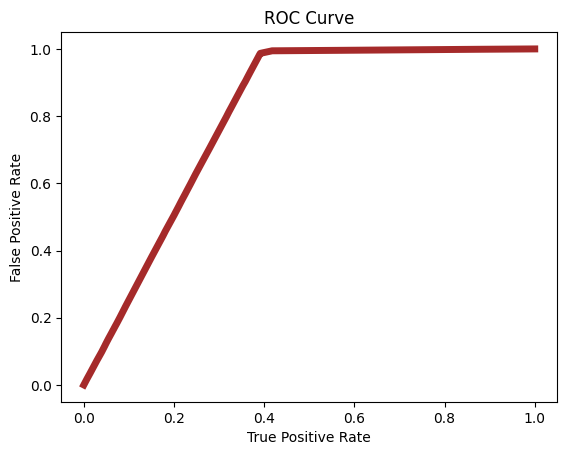

TrainSet areaUnderROC: 0.800201220340569


In [33]:
trainSet = rfModel.summary
roc = trainSet.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'],linewidth = '5',color = 'Brown')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('TrainSet areaUnderROC: ' + str(trainSet.areaUnderROC))

In [30]:
rfPredictions = predictions.select('CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 'DebtToIncomeRatio','rawPrediction','prediction', 'probability').show(10)

+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|CreditScore|AnnualIncome|LoanAmount|LoanDuration|Age|  DebtToIncomeRatio|       rawPrediction|prediction|         probability|
+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|        300|       15780|     20762|          19| 20| 0.6165116796740844|[18.7121542333932...|       0.0|[0.93560771166966...|
|        300|       24090|     19007|          14| 28| 0.6224856021534455|[18.4367547927549...|       0.0|[0.92183773963774...|
|        300|       31909|     13794|          21| 32| 0.6266177646305753|[19.8858121955325...|       0.0|[0.99429060977662...|
|        300|       32493|     22488|          21| 68| 0.5549893971977383|[19.1506520571610...|       0.0|[0.95753260285805...|
|        300|       32531|     20757|           8| 65| 0.6317061996914932|[18.7837228772455...|       0.

In [31]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Select the necessary columns
rfPredictions = predictions.select('CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age', 
                                   'DebtToIncomeRatio', 'rawPrediction', 'prediction', 'probability')

# Define the window spec for ordering the rows (e.g., by CreditScore or another column)
windowSpec = Window.orderBy("CreditScore")  # You can change the ordering column if needed

# Add a row number to each row
rfPredictions_with_row_num = rfPredictions.withColumn("row_num", F.row_number().over(windowSpec))

# Get the total count of rows
total_count = rfPredictions_with_row_num.count()

# Filter to get the last 100 rows
last_100_rfPredictions = rfPredictions_with_row_num.filter(rfPredictions_with_row_num["row_num"] > total_count - 100)

# Show the last 100 rows in the same format
last_100_rfPredictions.drop("row_num").show(10)


+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|CreditScore|AnnualIncome|LoanAmount|LoanDuration|Age|  DebtToIncomeRatio|       rawPrediction|prediction|         probability|
+-----------+------------+----------+------------+---+-------------------+--------------------+----------+--------------------+
|        849|       72227|     24792|          19| 55| 0.8967883254362617|[8.49786505894218...|       1.0|[0.42489325294710...|
|        849|       72392|     19037|           2| 61|   0.57723049229739|[8.71498382960940...|       1.0|[0.43574919148047...|
|        849|       72899|     16723|          26| 40|0.47600524749806095|[8.70042083717879...|       1.0|[0.43502104185893...|
|        849|       73107|     21706|          24| 62| 0.7815867075014731|[8.50262062028733...|       1.0|[0.42513103101436...|
|        849|       73332|     33549|          22| 19|0.23238595804709017|[8.68594141028236...|       1.